# Why stopping AB tests early can be a disaster

In [372]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import scipy.stats as stats

In [106]:
SAMPLE_SIZE = 500
#A_PERCENTAGE = 0.5
EFFECT_SIZE = 5

In [107]:
data = pd.DataFrame(
	{"participant_ID": list(range(1, SAMPLE_SIZE+1)),
	"KPI": np.random.normal(20, 10, SAMPLE_SIZE).round(),
	"group": rd.choices(["A",'B'], k= SAMPLE_SIZE)}
	)

In [108]:
SAMPLE_SIZE_B = len(data.loc[data.group == 'B','KPI'])
data.loc[data.group == 'B','KPI'] = data.loc[data.group == 'B','KPI'] + np.random.normal(EFFECT_SIZE,1, SAMPLE_SIZE_B).round()

In [109]:
data.head()

,participant_ID,KPI,group
0,1,13.0,A
1,2,37.0,B
2,3,37.0,A
3,4,11.0,B
4,5,27.0,B


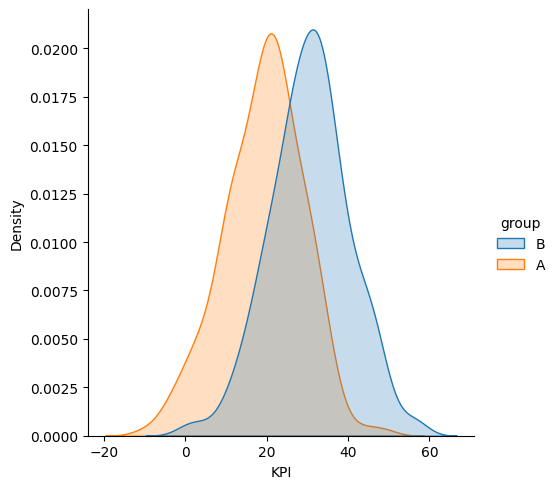

In [83]:
sns.displot(data, x = 'KPI',hue = 'group', kind = 'kde', fill = True)
plt.show()

## Simulation with functions

In [288]:
SAMPLE_SIZE = 500
#A_PERCENTAGE = 0.5
EFFECT_SIZE = 0
KPI_MEAN = 50
KPI_SD = 30

In [289]:
def simulate_data(SAMPLE_SIZE,EFFECT_SIZE):
	
	data = pd.DataFrame(
		{"participant_ID": list(range(1, SAMPLE_SIZE+1)),
		"KPI": np.random.normal(KPI_MEAN, KPI_SD, SAMPLE_SIZE).round(),
		"group": rd.choices(["A",'B'], k= SAMPLE_SIZE)})
	SAMPLE_SIZE_B = len(data.loc[data.group == 'B','KPI'])

	data.loc[data.group == 'B','KPI'] = data.loc[data.group == 'B','KPI'] + np.random.normal(EFFECT_SIZE,1, SAMPLE_SIZE_B).round()

	return data

def run_test(data):
    
    T_test = stats.ttest_ind(data.loc[data.group == 'A','KPI'],
                    		 data.loc[data.group == 'B','KPI'])
    p_value = T_test[1].round(2)

    return p_value

In [290]:
data = simulate_data(SAMPLE_SIZE,EFFECT_SIZE)

#[data.loc[data.group == 'A','KPI'].mean(), data.loc[data.group == 'B','KPI'].mean(),data.loc[data.group == 'A','KPI'].std(), data.loc[data.group == 'B','KPI'].std()]
run_test(data)

0.29

## The dance of the p_values

Run this a bunch of times. It will randomly generate data, then it will take the first 100 data points, run the t-test, plot the result. Then it will collect 10 more datapoints and run the test again, collect 10 more, run again and keep going till it reaches max sample size. Watch how the P-value dances! 

When it gets really interesting is if we run it with EFFECT_SIZE = 0. We can then see what the dance looks like when there is no effect. Notice how sometimes you'll see that that the effect becomes significant, then spring back up to being non significant. Each datapoint represents a time when we could have stopped the experiment. Notice how often we'd stop the study adn conclude success, and never realise that had we collected more data our result would have disappeared!

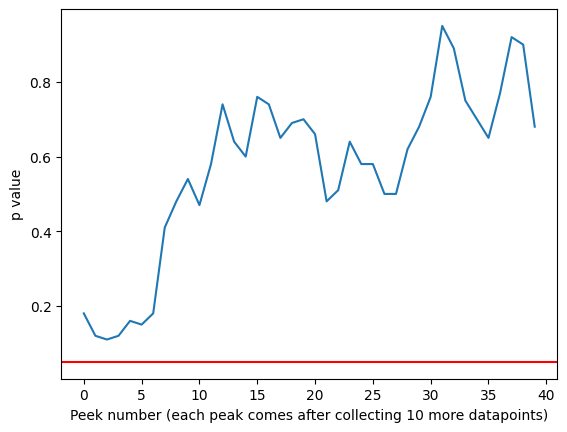

In [305]:
data = simulate_data(SAMPLE_SIZE,EFFECT_SIZE)
p_values = []
for run in range(100,SAMPLE_SIZE-1,10):
    data_experiment = data.iloc[0:run,:]
    #print(data_experiment.head())
    p_values.append(run_test(data_experiment))

dance_of_the_p_values = sns.lineplot (data = p_values)
dance_of_the_p_values.axhline(0.05, color = 'red')
dance_of_the_p_values.set(xlabel = 'Peek number (each peak comes after collecting 10 more datapoints)', ylabel= 'p value')
plt.show()

### What is our false positive rate?

In [366]:
def full_simulation(N_SIMULATIONS, START_PEEKING,PEEK_AFTER,EFFECT_SIZE,SAMPLE_SIZE):
    NUMBER_OF_PEEKS = ((SAMPLE_SIZE-START_PEEKING) / PEEK_AFTER) +1

    simulation_results = np.repeat(0,N_SIMULATIONS)

    print('Simulating', N_SIMULATIONS, 'AB tests where the real effect size is', EFFECT_SIZE,
        '. We collect',START_PEEKING,'data points then we peek at the data. Then we collect data until we have',
        SAMPLE_SIZE, ' datapoints, checking for a significant result every',PEEK_AFTER, 'data points. As a result we could peek up to',NUMBER_OF_PEEKS,'times. As soon as we get a significant result we stop the study and declare success')

    for sim in range(N_SIMULATIONS):

        data = simulate_data(SAMPLE_SIZE,EFFECT_SIZE)

        for run in range(START_PEEKING,SAMPLE_SIZE-1,PEEK_AFTER):
            data_experiment = data.iloc[0:run,:]
            if run_test(data_experiment) < 0.05:
                simulation_results[sim] = 1
                break
    print('Success rate is:',(np.array(simulation_results).mean()*100).round(),'% with',NUMBER_OF_PEEKS,'peeks')


In [367]:
full_simulation(N_SIMULATIONS = 10000, START_PEEKING = 100,PEEK_AFTER = 100,EFFECT_SIZE = 0, SAMPLE_SIZE = 500)

Simulating 10000 AB tests where the real effect size is 0 . We collect 100 data points then we peek at the data. Then we collect data until we have 500  datapoints, checking for a significant result every 100 data points. As a result we could peek up to 5.0 times. As soon as we get a significant result we stop the study and declare success
Success rate is: 11.0 % with 5.0 peeks


In [368]:
full_simulation(N_SIMULATIONS = 10000, START_PEEKING = 100, PEEK_AFTER = 50, EFFECT_SIZE = 0, SAMPLE_SIZE = 500)

Simulating 10000 AB tests where the real effect size is 0 . We collect 100 data points then we peek at the data. Then we collect data until we have 500  datapoints, checking for a significant result every 50 data points. As a result we could peek up to 9.0 times. As soon as we get a significant result we stop the study and declare success
Success rate is: 14.0 % with 9.0 peeks
